# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# Using prettyTable for showing the observations
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ["Vectorizer", "Model", "Hyperparameters", "AUC Score"]
print(table)

+------------+-------+-----------------+-----------+
| Vectorizer | Model | Hyperparameters | AUC Score |
+------------+-------+-----------------+-----------+
+------------+-------+-----------------+-----------+


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

# We are taking 60k positive and negative points to keep data balanced
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score in (1,2) LIMIT 50000 """, con) 
filtered_data = filtered_data.append(
                    pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score in (4,5) LIMIT 50000 """, con))

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1


#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(83317, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

83.317

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(83315, 10)


1    45420
0    37895
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I am so glad this seller. I bought several things from her and she gave me a refund on the combined shipping costs.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These rose buds from Catey13 are precious They have a soft aroma and a pretty look to them I plan to use them for small sachets in the bags I bought from catey13 and use rose colored ribbon to adorn the bags I am so glad this seller I bought several things from her and she gave me a refund on the combined shipping costs 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
review_score = []    # Storing score for later
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)   # adding 0-9 in the regex
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 83315/83315 [00:44<00:00, 1871.65it/s]


In [24]:
preprocessed_reviews[1500]

'rose buds precious soft aroma pretty look plan use small sachets bags bought use rose colored ribbon adorn bags glad seller bought several things gave refund combined shipping costs'

In [25]:
len(preprocessed_reviews)

83315

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 83315/83315 [00:20<00:00, 4141.03it/s]


In [27]:
preprocessed_text = [list(a) for a in zip(preprocessed_reviews, preprocessed_summary)]
print(preprocessed_text[:5])

[['one best children books ever written mini version book not portrayed one priced product sent email regarding bewilderment amazon got no response', 'awesome book poor size'], ['give five stars maurice sendak story one star printed edition book children older copy book familiar previous softcover version ordered granddaughters embarrassed give gift looks puny book size postcard think overpriced learned lesson not buying softcover children books next time get used copy', 'story great softcover book disappointing'], ['dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports', 'made china'], ['dogs love saw pet store tag attached regarding made china satisfied safe', 'dog lover delites'], ['received containers previously opened seals opened top containers decent pieces liver grisley pieces lot powder bottom never buy liver treats amazon big rip', 'review freeze dried liver treats dog

# [4] Featurization

In [28]:
# importing train_test_split to split data for Naive Bayes

from sklearn.model_selection import train_test_split

In [29]:
# this is random splitting into train, test and cross validation set
ppReview_train, ppReview_test, rs_train, rs_test = train_test_split(preprocessed_reviews, review_score, 
                                                                    test_size=0.30, random_state = 0) 

In [30]:
ppReview_train[:3]

['little disappointed mild tried brewing stronger not cup tea',
 'singapore satay favourite food lkk satay sauce much tamarind peanuts ground finely like eating coarse sugar yeo brand makes better satay sauce tried could not find yeo brand let back yeo sure note satay marinade not satay sauce',
 'bottom lineif expecting rising pizza crust might get standard pizza dough need look elsewhere said pretty good right tastei rather like way pizza crusts taste toasted soak flavor sauce cheese well without becoming soggy wilted good bread flavor also make good base bbq chicken bbq pulled pork pizza texturei think texture thing complain schar crusts little dense would like however usual complaint gluten free items sizethese definitely personal pizza sized sauce cheese toppings crust usually eat pizza uses versatilityif expand mind beyond making pizza red sauce mozzarella crusts quite useful personally love bbq sauce chicken make nice bread carb base anything might otherwise eat flatbread gluten 

## [4.1] BAG OF WORDS

In [83]:
#BoW
# changing ngram_range to (1, 2)
count_vect = CountVectorizer(ngram_range=(1,2), min_df=5) #in scikit-learn
count_vect.fit(ppReview_train)
print("Total training features : ", len(count_vect.get_feature_names()))
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)


bow_train = count_vect.transform(ppReview_train)
bow_test = count_vect.transform(ppReview_test)

print("\nShapes After Vectorization ")
print(bow_train.shape, len(rs_train))
print(bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

Total training features :  78250
some feature names  ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abbott', 'abc', 'abdominal', 'abdominal pain', 'abilities']

Shapes After Vectorization 
(58320, 78250) 58320
(24995, 78250) 24995
Unique words in training :  78250


## [4.2] Bi-Grams and n-Grams.

In [32]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (83315, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [33]:
#tf-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(ppReview_train)
print("Total training features : ", len(tf_idf_vect.get_feature_names()))
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfIdf_train = tf_idf_vect.transform(ppReview_train)
tfIdf_test = tf_idf_vect.transform(ppReview_test)
print("\nShapes After Vectorization ")
print(tfIdf_train.shape, len(rs_train))
print(tfIdf_test.shape, len(rs_test))
print("Unique words in training : ", tfIdf_train.get_shape()[1])

Total training features :  78250
some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abbott', 'abc', 'abdominal', 'abdominal pain', 'abilities']

Shapes After Vectorization 
(58320, 78250) 58320
(24995, 78250) 24995
Unique words in training :  78250


## [4.4] Word2Vec

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [35]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8516759872436523), ('fantastic', 0.850843071937561), ('terrific', 0.8320370316505432), ('good', 0.8240129947662354), ('excellent', 0.8080400824546814), ('wonderful', 0.7716935873031616), ('amazing', 0.7684472799301147), ('perfect', 0.7617061138153076), ('nice', 0.6849722862243652), ('decent', 0.6590705513954163)]
[('nastiest', 0.8589358925819397), ('best', 0.7098000049591064), ('greatest', 0.7057880759239197), ('disgusting', 0.6686980128288269), ('weakest', 0.6653167605400085), ('vile', 0.6649082899093628), ('tastiest', 0.6362621784210205), ('grossest', 0.6314499974250793), ('blandest', 0.6236517429351807), ('terrible', 0.6198409795761108)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17612
sample words  ['one', 'best', 'children', 'books', 'ever', 'written', 'mini', 'version', 'book', 'not', 'portrayed', 'priced', 'product', 'sent', 'email', 'regarding', 'amazon', 'got', 'no', 'response', 'give', 'five', 'stars', 'story', 'star', 'printed', 'edition', 'older', 'copy', 'familiar', 'previous', 'ordered', 'granddaughters', 'embarrassed', 'gift', 'looks', 'puny', 'size', 'think', 'overpriced', 'learned', 'lesson', 'buying', 'next', 'time', 'get', 'used', 'dogs', 'loves', 'chicken']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [37]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 83315/83315 [03:42<00:00, 375.21it/s]

83315
50


#### [4.4.1.2] TFIDF weighted W2v

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [49]:
def nb_classifier(X_Train, y_train):
    """
    This method is a wrapper over the actual naive bayes classifier. It will return the most optimal value 
    of Alpha based on the results obtained in cross_validation after running the algorithm on the given dataset.
    """
    alphaList = np.array([0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 
                          1, 5, 10, 50, 100, 500])
    params_Dict = {'alpha' : alphaList}
    nb_Optimal = MultinomialNB()
    grid = GridSearchCV(estimator=nb_Optimal, param_grid=params_Dict, scoring='roc_auc', n_jobs=4, cv=5)
    grid_result = grid.fit(X_Train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
    
    plt.figure(figsize=(10.0, 8.0))
    plt.plot(np.log10(alphaList), train_auc, label='Train AUC vs Alpha')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(np.log10(alphaList), train_auc - train_auc_std, train_auc + train_auc_std,
                           alpha=0.2, color='darkblue')

    plt.plot(np.log10(alphaList), cv_auc, label='CV AUC vs Alpha')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(np.log10(alphaList), cv_auc - cv_auc_std, cv_auc + cv_auc_std,
                           alpha=0.2, color='darkorange')
    plt.title("Area under ROC vs Alpha")
    plt.xlabel("Alpha")
    plt.ylabel("Area")
    plt.legend(loc="lower left")
    plt.show()

In [50]:
def draw_Confusion_Matrix(actual, predicted):
    class_label = ["negative", "positive"]
    conf_matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
    hm = sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

Optimal Parameters :  {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


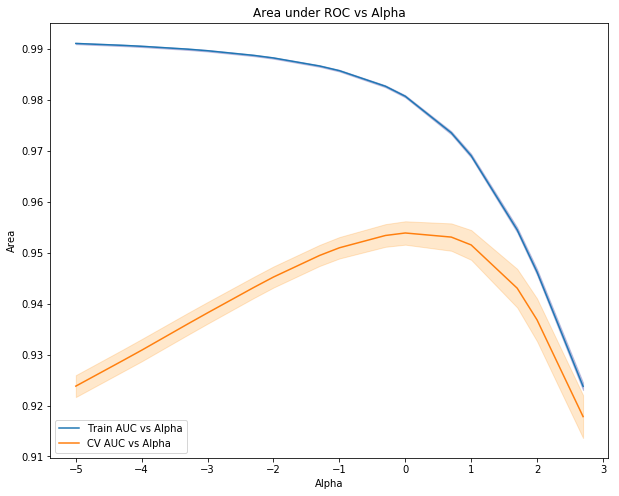

In [84]:
# Please write all the code with proper documentation
nb_classifier(bow_train, rs_train)

Using Alpha value for NB -  1.0
Train accuracy for optimal NB using BOW 93.48
Test accuracy for optimal NB using BOW 89.93


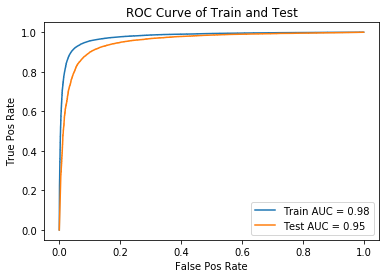

In [85]:
# training the optimal Naive Bayes Classifier using optimal alpha values for BOW vectors
optimal_alpha_bow=1.0
nb_optimal_bow = MultinomialNB(alpha=optimal_alpha_bow)
nb_optimal_bow.fit(bow_train, rs_train)

# Prediction on training and test set using optimal
problog_bow_train = nb_optimal_bow.predict_log_proba(bow_train)
problog_bow_test = nb_optimal_bow.predict_log_proba(bow_test)
pred_bow_train = np.argmax(problog_bow_train, axis =1)
pred_bow_test = np.argmax(problog_bow_test, axis =1)
print("Using Alpha value for NB - ", optimal_alpha_bow)
print("Train accuracy for optimal NB using BOW", round(accuracy_score(rs_train, pred_bow_train)*100, 2))
print("Test accuracy for optimal NB using BOW", round(accuracy_score(rs_test, pred_bow_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, problog_bow_train[:, 1], pos_label=1)
test_fpr, test_tpr, thresholds = roc_curve(rs_test, problog_bow_test[:, 1], pos_label=1)

# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


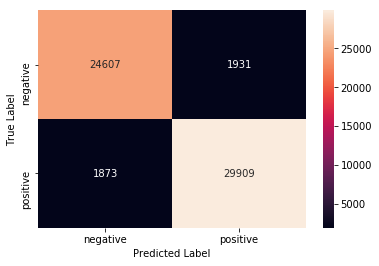




Test Confusion Matrix


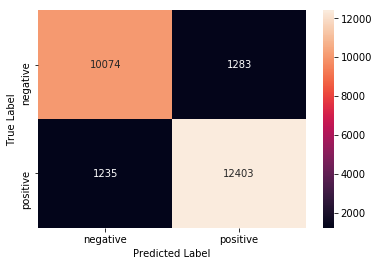

In [86]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_bow_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_bow_test)
table.add_row(["BOW", "Multi-Nomial NB", optimal_alpha_bow, auc_score])

In [87]:
# Classification report 
print(classification_report(rs_test, pred_bow_test))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     11357
           1       0.91      0.91      0.91     13638

   micro avg       0.90      0.90      0.90     24995
   macro avg       0.90      0.90      0.90     24995
weighted avg       0.90      0.90      0.90     24995



### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [137]:
# Please write all the code with proper documentation
# We need the indices of the sorted feature array, and we will use them to get the feature names from the 
# count vectors

# # nb_optimal_bow.feature_count_.shape
# print(nb_optimal_bow.feature_log_prob_[1, :])
print("Top 10 Positive class features are : ")
print(np.take(count_vect.get_feature_names(), nb_optimal_bow.feature_log_prob_[1, :].argsort()[:-11:-1]))

Top 10 Positive class features are : 
['not' 'like' 'good' 'great' 'one' 'taste' 'tea' 'coffee' 'love' 'flavor']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [138]:
# Please write all the code with proper documentation

print("Top 10 Negative class features are : ")
print(np.take(count_vect.get_feature_names(), nb_optimal_bow.feature_log_prob_[0, :].argsort()[:-11:-1]))

Top 10 Negative class features are : 
['not' 'like' 'would' 'product' 'taste' 'one' 'good' 'coffee' 'no'
 'flavor']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

Optimal Parameters :  {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


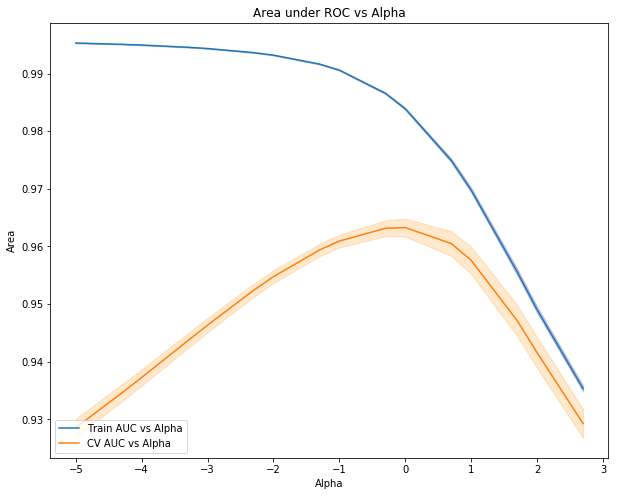

In [139]:
# Please write all the code with proper documentation
nb_classifier(tfIdf_train, rs_train)

Using Alpha value for NB -  1.0
Train accuracy for optimal NB using Tf-Idf 93.39
Test accuracy for optimal NB using Tf-Idf 89.75


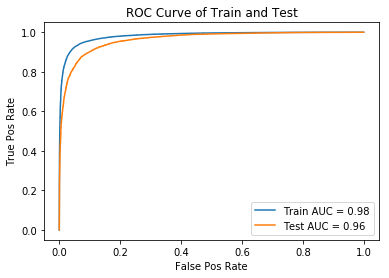

In [140]:
# training the optimal Naive Bayes Classifier using optimal alpha values for Tf-IDF vectors
optimal_alpha_tf=1.0
nb_optimal_tf = MultinomialNB(alpha=optimal_alpha_tf)
nb_optimal_tf.fit(tfIdf_train, rs_train)

# Prediction on training and test set using optimal
problog_tf_train = nb_optimal_tf.predict_log_proba(tfIdf_train)
problog_tf_test = nb_optimal_tf.predict_log_proba(tfIdf_test)
pred_tf_train = np.argmax(problog_tf_train, axis =1)
pred_tf_test = np.argmax(problog_tf_test, axis =1)
print("Using Alpha value for NB - ", optimal_alpha_tf)
print("Train accuracy for optimal NB using Tf-Idf", round(accuracy_score(rs_train, pred_tf_train)*100, 2))
print("Test accuracy for optimal NB using Tf-Idf", round(accuracy_score(rs_test, pred_tf_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, problog_tf_train[:, 1], pos_label=1)
test_fpr, test_tpr, thresholds = roc_curve(rs_test, problog_tf_test[:, 1], pos_label=1)

# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


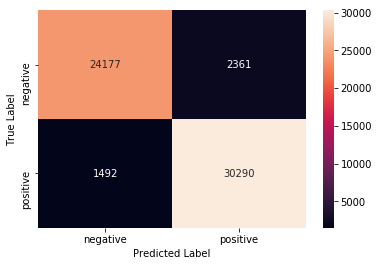




Test Confusion Matrix


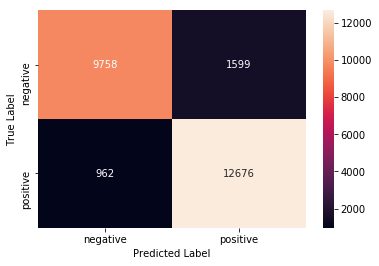

In [141]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_tf_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_tf_test)
table.add_row(["Tf-Idf", "Multi-Nomial NB", optimal_alpha_tf, auc_score])

In [142]:
# Classification report 
print(classification_report(rs_test, pred_tf_test))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88     11357
           1       0.89      0.93      0.91     13638

   micro avg       0.90      0.90      0.90     24995
   macro avg       0.90      0.89      0.90     24995
weighted avg       0.90      0.90      0.90     24995



### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [143]:
# Please write all the code with proper documentation

# We need the indices of the sorted feature array, and we will use them to get the feature names from the 
# count vectors

print("Top 10 Positive class features are : ")
print(np.take(tf_idf_vect.get_feature_names(), nb_optimal_tf.feature_log_prob_[1, :].argsort()[:-11:-1]))

Top 10 Positive class features are : 
['not' 'great' 'good' 'tea' 'like' 'love' 'coffee' 'one' 'flavor'
 'product']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [144]:
# Please write all the code with proper documentation

print("Top 10 Negative class features are : ")
print(np.take(tf_idf_vect.get_feature_names(), nb_optimal_tf.feature_log_prob_[0, :].argsort()[:-11:-1]))

Top 10 Negative class features are : 
['not' 'like' 'product' 'taste' 'would' 'coffee' 'one' 'flavor' 'no'
 'good']


# [6] Trying again after including summary as feature

### BOW

In [101]:
# this is random splitting into train and test set
# preprocessed_text = preprocessed_reviews + preprocessed_summary
ppReview_train, ppReview_test, rs_train, rs_test = train_test_split(preprocessed_text, review_score, 
                                                                    test_size=0.30, random_state = 0) 

# Merging the two features into one
ppReview_train = [' '.join(s) for s in ppReview_train]
ppReview_test = [' '.join(s) for s in ppReview_test]

#BoW
# changing ngram_range to (1, 2)
count_vect = CountVectorizer(ngram_range=(1,2), min_df=5) #in scikit-learn
count_vect.fit(ppReview_train)
print("Total training features : ", len(count_vect.get_feature_names()))
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_train = count_vect.transform(ppReview_train)
bow_test = count_vect.transform(ppReview_test)

print("\nShapes After Vectorization ")
print(bow_train.shape, len(rs_train))
print(bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

Total training features :  82951
some feature names  ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abbott', 'abc', 'abdominal', 'abdominal pain', 'abilities']

Shapes After Vectorization 
(58320, 82951) 58320
(24995, 82951) 24995
Unique words in training :  82951


Optimal Parameters :  {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


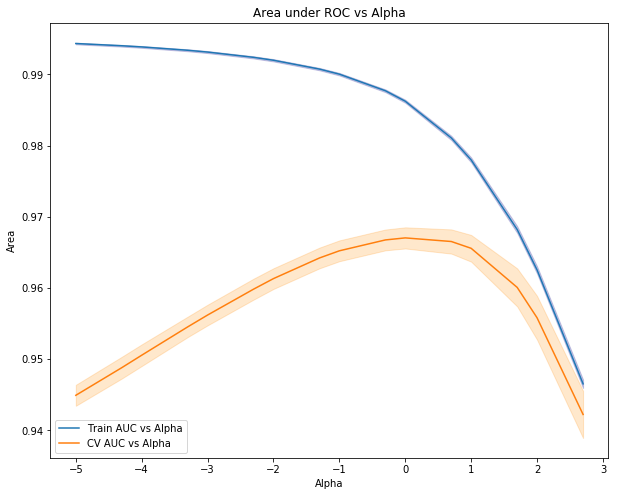

In [102]:
# Applying naive bayes on new merged features
nb_classifier(bow_train, rs_train)

Using Alpha value for NB -  1.0
Train accuracy for optimal NB using BOW 94.81
Test accuracy for optimal NB using BOW 91.89


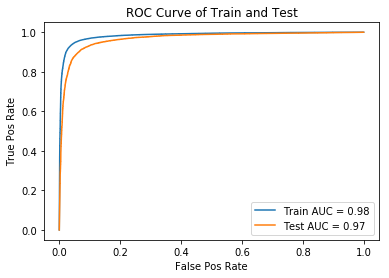

In [104]:
# training the optimal Naive Bayes Classifier using optimal alpha values for BOW vectors
optimal_alpha_bow=1.0
nb_optimal_bow = MultinomialNB(alpha=optimal_alpha_bow)
nb_optimal_bow.fit(bow_train, rs_train)

# Prediction on training and test set using optimal
problog_bow_train = nb_optimal_bow.predict_log_proba(bow_train)
problog_bow_test = nb_optimal_bow.predict_log_proba(bow_test)
pred_bow_train = np.argmax(problog_bow_train, axis =1)
pred_bow_test = np.argmax(problog_bow_test, axis =1)
print("Using Alpha value for NB - ", optimal_alpha_bow)
print("Train accuracy for optimal NB using BOW", round(accuracy_score(rs_train, pred_bow_train)*100, 2))
print("Test accuracy for optimal NB using BOW", round(accuracy_score(rs_test, pred_bow_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, problog_bow_train[:, 1], pos_label=1)
test_fpr, test_tpr, thresholds = roc_curve(rs_test, problog_bow_test[:, 1], pos_label=1)

# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


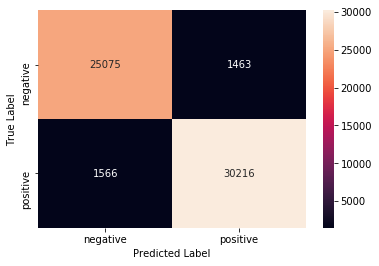




Test Confusion Matrix


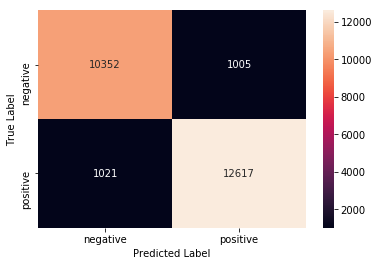

In [109]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_bow_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_bow_test)
table.add_row(["2-feature BOW", "Multi-Nomial NB", optimal_alpha_bow, auc_score])

In [110]:
# Classification report 
print(classification_report(rs_test, pred_bow_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     11357
           1       0.93      0.93      0.93     13638

   micro avg       0.92      0.92      0.92     24995
   macro avg       0.92      0.92      0.92     24995
weighted avg       0.92      0.92      0.92     24995



### Tf-Idf

In [111]:
# this is random splitting into train and test set
ppReview_train, ppReview_test, rs_train, rs_test = train_test_split(preprocessed_text, review_score, 
                                                                    test_size=0.30, random_state = 0) 

# Merging the two features into one
ppReview_train = [' '.join(s) for s in ppReview_train]
ppReview_test = [' '.join(s) for s in ppReview_test]

#tf-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(ppReview_train)
print("Total training features : ", len(tf_idf_vect.get_feature_names()))
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfIdf_train = tf_idf_vect.transform(ppReview_train)
tfIdf_test = tf_idf_vect.transform(ppReview_test)
print("\nShapes After Vectorization ")
print(tfIdf_train.shape, len(rs_train))
print(tfIdf_test.shape, len(rs_test))
print("Unique words in training : ", tfIdf_train.get_shape()[1])

Total training features :  82951
some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abbott', 'abc', 'abdominal', 'abdominal pain', 'abilities']

Shapes After Vectorization 
(58320, 82951) 58320
(24995, 82951) 24995
Unique words in training :  82951


Optimal Parameters :  {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


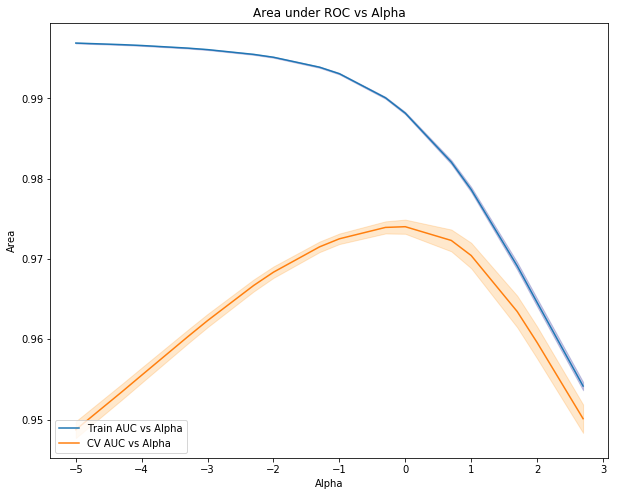

In [112]:
# Please write all the code with proper documentation
nb_classifier(tfIdf_train, rs_train)

Using Alpha value for NB -  1.0
Train accuracy for optimal NB using Tf-Idf 94.59
Test accuracy for optimal NB using Tf-Idf 91.78


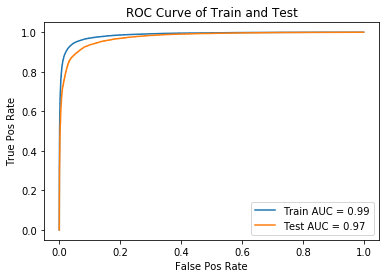

In [113]:
# training the optimal Naive Bayes Classifier using optimal alpha values for Tf-IDF vectors
optimal_alpha_tf=1.0
nb_optimal_tf = MultinomialNB(alpha=optimal_alpha_tf)
nb_optimal_tf.fit(tfIdf_train, rs_train)

# Prediction on training and test set using optimal
problog_tf_train = nb_optimal_tf.predict_log_proba(tfIdf_train)
problog_tf_test = nb_optimal_tf.predict_log_proba(tfIdf_test)
pred_tf_train = np.argmax(problog_tf_train, axis =1)
pred_tf_test = np.argmax(problog_tf_test, axis =1)
print("Using Alpha value for NB - ", optimal_alpha_tf)
print("Train accuracy for optimal NB using Tf-Idf", round(accuracy_score(rs_train, pred_tf_train)*100, 2))
print("Test accuracy for optimal NB using Tf-Idf", round(accuracy_score(rs_test, pred_tf_test) * 100, 2))

# ROC-AUC on train & test data
train_fpr, train_tpr, thresholds = roc_curve(rs_train, problog_tf_train[:, 1], pos_label=1)
test_fpr, test_tpr, thresholds = roc_curve(rs_test, problog_tf_test[:, 1], pos_label=1)

# Draw ROC curve
plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(auc(train_fpr, train_tpr), 2)))
auc_score = round(auc(test_fpr, test_tpr), 2)
plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
plt.legend()
plt.xlabel("False Pos Rate")
plt.ylabel("True Pos Rate")
plt.title("ROC Curve of Train and Test")
plt.show()

Training Confusion Matrix


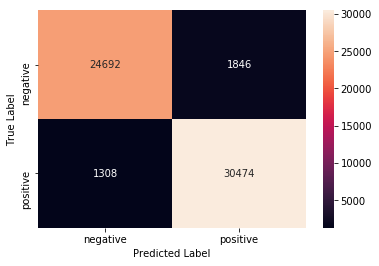




Test Confusion Matrix


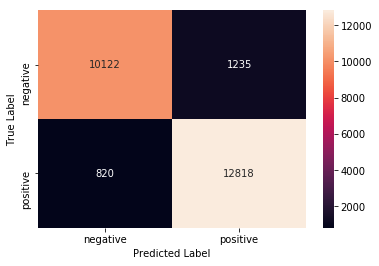

In [114]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_tf_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_tf_test)
table.add_row(["2-feature Tf-Idf", "Multi-Nomial NB", optimal_alpha_tf, auc_score])

In [116]:
# Classification report 
print(classification_report(rs_test, pred_tf_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     11357
           1       0.91      0.94      0.93     13638

   micro avg       0.92      0.92      0.92     24995
   macro avg       0.92      0.92      0.92     24995
weighted avg       0.92      0.92      0.92     24995



# [7] Conclusions

In [117]:
# Please compare all your models using Prettytable library
print(table)

+------------------+-----------------+-----------------+-----------+
|    Vectorizer    |      Model      | Hyperparameters | AUC Score |
+------------------+-----------------+-----------------+-----------+
|       BOW        | Multi-Nomial NB |       1.0       |    0.95   |
|      Tf-Idf      | Multi-Nomial NB |       1.0       |    0.96   |
|  2-feature BOW   | Multi-Nomial NB |       1.0       |    0.97   |
| 2-feature Tf-Idf | Multi-Nomial NB |       1.0       |    0.97   |
+------------------+-----------------+-----------------+-----------+


1. Naive Bayes prooves to be a much better classsifier compared to kNN. It is much faster.
2. The alpha value comes out to 1.0 as the optimal value for all cases. This is experimental.
3. We are also getting a good score of AUC as compared to kNN.
4. By checking the Test Accuracy and F1-Score we can easily deduce that BOW vector model performs slightly 
    better than Tf-Idf.
5. Also, we can see that concatenating the summary text with the review text also adds to the feature set
    and improves the classifier accuracy.